### Introduction

In this example notebook we outline how to employ the HEOM to 
solve the FMO photosynthetic complex dynamics. 


We aim to replicate the results in reference https://www.pnas.org/content/106/41/17255
and compare them to a Bloch-Redfield (perturbative) solution.


In [1]:
%pylab inline
from qutip import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:

from bofinpy.heom import BosonicHEOMSolver

In [5]:

def cot(x):
    return 1./np.tan(x)

def c(t):
    c_temp =[]
    c_temp.append(lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1,5):
        vk = 2 * np.pi * k * T
        c_temp.append( (4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    return c_temp

def J0(energy):
    #underdamped brownian oscillator

    return 2 * lam * gamma * (energy)/( ((energy**2) + (gamma**2)))



/home/neill/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


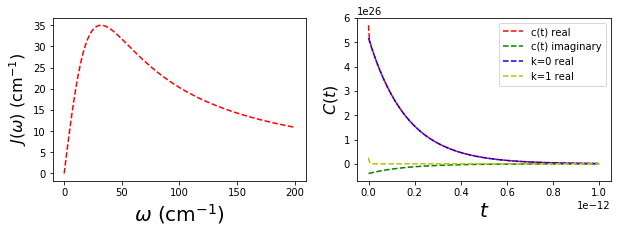

In [6]:
#A quick plot of the spectral density and environment correlation functions


wlist = linspace(0, 200*3e10*2*pi,100)
lam = 35 * 3e10 * 2 * pi
gamma = (1/(166e-15))
T = 300 * 0.6949 * 3e10 * 2 * pi

beta = 1/T

#gamma = 1.0

#lam = 2.5/2.

#T = 1/0.95
tlist = linspace(0,1.e-12,1000)


J = [J0(w)/(3e10*2*pi) for w in wlist]


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,3))

fig.subplots_adjust(hspace=0.1) # reduce space between plots

axes[0].plot(wlist/(3e10*2*pi), J, color='r',ls='--')
axes[0].set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=20)
axes[0].set_ylabel(r"$J(\omega)$ (cm$^{-1}$)", fontsize=16);
axes[1].plot(tlist, [np.real(sum(c(t))) for t in tlist], color='r',ls='--',label="c(t) real")
axes[1].plot(tlist, [np.imag(sum(c(t))) for t in tlist], color='g',ls='--',label="c(t) imaginary")
axes[1].plot(tlist, [c(t)[0] for t in tlist], color='b',ls='--',label="k=0 real")
axes[1].plot(tlist, [c(t)[1] for t in tlist], color='y',ls='--',label="k=1 real")
axes[1].set_xlabel(r'$t$', fontsize=20)
axes[1].set_ylabel(r"$C(t)$", fontsize=16);

axes[1].legend(loc=0)

fig.savefig("drude.pdf")

In [7]:


#We use the Hamiltonian employed in  https://www.pnas.org/content/106/41/17255 and operate in units of Hz
Hsys =  3e10 * 2 * pi *Qobj([[200, -87.7, 5.5, -5.9, 6.7, -13.7, -9.9],
                    [-87.7, 320, 30.8, 8.2, 0.7, 11.8, 4.3],
                    [5.5, 30.8, 0, -53.5, -2.2, -9.6, 6.0],
                    [-5.9, 8.2, -53.5, 110, -70.7, -17.0, -63.3],
                    [6.7, 0.7, -2.2, -70.7, 270, 81.1, -1.3],
                    [-13.7,11.8, -9.6, -17.0 ,81.1, 420, 39.7],
                    [-9.9, 4.3, 6.0, -63.3, -1.3, 39.7, 230]])


#start the excitation at site :1:
rho0 = basis(7,0)*basis(7,0).dag() 

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-17,atol=1e-17)
#
Nc = 8

Nk = 1


pref = 1

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAR)
print(ckAI)
print(vkAR)
print(vkAI)



NR = len(ckAR)
NI = len(ckAI)
Q2 = []
ckAR2 = []
ckAI2 = []
vkAR2 = []
vkAI2 = []
for m in range(7):
    Q2.extend([ basis(7,m)*basis(7,m).dag() for kk in range(NR)])
    ckAR2.extend(ckAR)    
    vkAR2.extend(vkAR)
   
for m in range(7):
    Q2.extend([ basis(7,m)*basis(7,m).dag() for kk in range(NI)])
    ckAI2.extend(ckAI)
    vkAI2.extend(vkAI)
    


options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)


HEOMMats = BosonicHEOMSolver(Hsys, Q2, ckAR2, ckAI2, vkAR2, vkAI2, Nc, options=options)
outputFMOHEOM=HEOMMats.run(rho0,tlist)


[(5.1747829575874685e+26+0j)]
[(-3.974303959360582e+25+0j)]
[(6024096385542.169+0j)]
[(6024096385542.169+0j)]


/mnt/d/github/qutip-heom/heom_fmotd.py:224: UserWarning: Expected simplified input.
  warnings.warn("Expected simplified input.")
/mnt/d/github/qutip-heom/heom_fmotd.py:229: UserWarning: Expected simplified input.
  warnings.warn("Expected simplified input.")


In [8]:

#Add Tanimura Terminator, vital to get convergence here.

NR = len(ckAR)
NI = len(ckAI)
Q2 = []
ckAR2 = []
ckAI2 = []
vkAR2 = []
vkAI2 = []
for m in range(7):
    Q2.extend([ basis(7,m)*basis(7,m).dag() for kk in range(NR)])
    ckAR2.extend(ckAR)    
    vkAR2.extend(vkAR)
   
for m in range(7):
    Q2.extend([ basis(7,m)*basis(7,m).dag() for kk in range(NI)])
    ckAI2.extend(ckAI)
    vkAI2.extend(vkAI)
    


Q_list=[basis(7,m)*basis(7,m).dag() for m in range(7)]
L_bnd = 0.0*spre(Q_list[0])*spost(Q_list[0].dag())
for Q1 in Q_list:
    op = -2*spre(Q1)*spost(Q1.dag()) + spre(Q1.dag()*Q1) + spost(Q1.dag()*Q1)

    approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

    approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma
    for k in range(1,Nk):
        vk = 2 * np.pi * k * T

        approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)

    L_bnd += -approx_factr*op


Ltot = liouvillian(Hsys) + L_bnd


HEOMMats = BosonicHEOMSolver(Ltot, Q2, ckAR2, ckAI2, vkAR2, vkAI2, Nc, options=options)
outputFMOHEOMT=HEOMMats.run(rho0,tlist)


In [13]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

In [14]:
from cycler import cycler

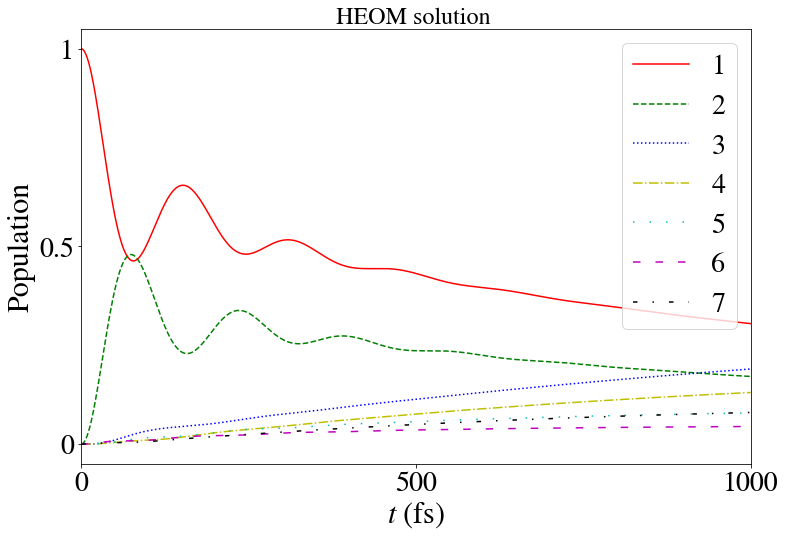

In [25]:
fig, axes = plt.subplots(1,1, figsize=(12,8))

default_cycler = (cycler(color=['r', 'g', 'b', 'y','c','m','k']) +
                  cycler(linestyle=['-', '--', ':', '-.',(0, (1, 10)), (0, (5, 10)),(0, (3, 10, 1, 10))]))
plt.rc('axes',prop_cycle=default_cycler )

for m in range(7):
    Q =  basis(7,m)*basis(7,m).dag()
    axes.plot(array(tlist)*1e15, expect(outputFMOHEOMT.states,Q),label=m+1)    
axes.set_xlabel(r'$t$ (fs)', fontsize=30)
axes.set_ylabel(r"Population", fontsize=30);
axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)

axes.set_title('HEOM solution ',fontsize=24)
axes.legend(loc=0)
axes.set_xlim(0,1000)
plt.yticks([0.,0.5,1],[0,0.5,1])
plt.xticks([0.,500,1000],[0,500,1000])
fig.savefig("fmoheom.pdf")


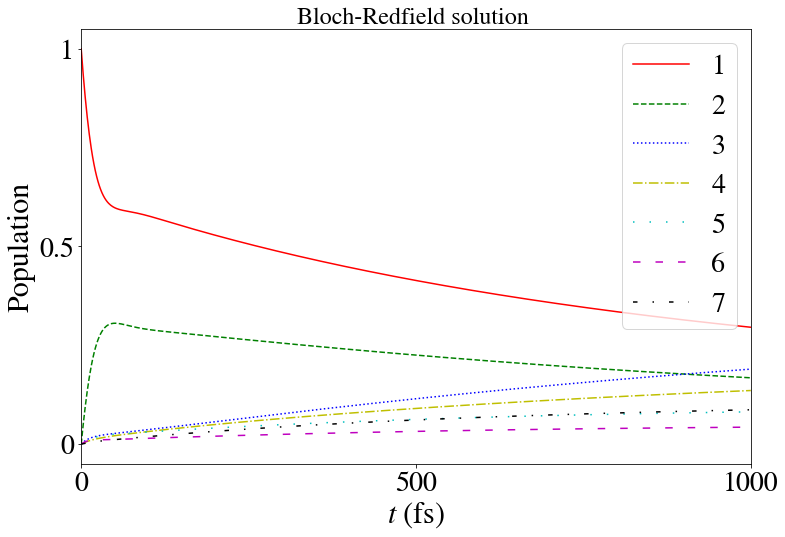

In [24]:

DL = " 2*pi* 2.0 * {lam} / (pi * {gamma} * {beta})  if (w==0) else 2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)".format(gamma=gamma, beta = beta, lam = lam)

Nmax = 7
Q_list = [basis(Nmax, n)*basis(Nmax, n).dag() for n in range(Nmax)]

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)
outputBR  =  brmesolve(Hsys, rho0, tlist, a_ops=[[Q,DL] for Q in Q_list], options = optionsODE)


fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(array(tlist)*1e15, expect(outputBR.states,Q),label=m+1)

axes.set_xlabel(r'$t$ (fs)', fontsize=30)
axes.set_ylabel(r"Population", fontsize=30);

axes.set_title('Bloch-Redfield solution ',fontsize=24)
axes.legend(loc=0)
axes.set_xlim(0,1000)
plt.yticks([0.,0.5,1],[0,0.5,1])
plt.xticks([0.,500,1000],[0,500,1000])
fig.savefig("fmoBR.pdf")

### Software versions

In [52]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.0.dev0
Numpy,1.18.1
SciPy,1.4.1
matplotlib,3.1.2
Cython,0.29.14
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,7.11.1
Python,"3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0]"
OS,posix [linux]
